# Truncate CoT 
On GSM8K, model arrives at solution multiple times (does it know it has gotten the answer?), we early exit from the think process and measure the logit and acc of getting the answer, including when it does think at all (immediate exit).

Use transformerlens as it allows to get logits easier? (not sure how to do with nnsight) Also i measured on MMLU (2 samples) for the logits between HF model and nnsight and TF, seems like TF is closer.

The dataset containing R1 response is taken from https://github.com/ARBORproject/arborproject.github.io/issues/8 along with some functions

In [1]:
import torch
import numpy as np
from utils import *
from wrapper import *
from tqdm import tqdm
from collections import defaultdict
from transformer_lens import utils, HookedTransformer
seed = 42
torch.cuda.manual_seed(seed)
np.random.seed(seed)
from einops import einsum
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

torch.set_grad_enabled(False)

In [2]:
model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
# model_path  = 'google/gemma-2-2b-it'
model = HookedTransformer.from_pretrained(
    model_path,
    center_unembed=False,
    center_writing_weights=False,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
    default_padding_side = 'left',
    default_prepend_bos = False,
    torch_dtype = torch.bfloat16,
)  

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model deepseek-ai/DeepSeek-R1-Distill-Llama-8B into HookedTransformer


Custom generate fn to return logits

In [3]:
from transformer_lens.past_key_value_caching import HookedTransformerKeyValueCache
@torch.inference_mode()
def generate_logits( 
    model,
    input_ids,
    attention_mask,
    answer,
    max_new_tokens = 10,
    take_prob = False,
):
    """
    1) we collect the logits for the correct answer (assume that model will output the exact str in GSM8K, there may be some small diff in commas, etc which is the limitation of this approach)
    2) So we also compare correctness by just getting the greedy answer and through str matching to see if it matches even if slightly different format
    3) take_prob collects prob instead of logits
    """
    past_kv_cache = HookedTransformerKeyValueCache.init_cache(model.cfg, model.cfg.device, input_ids.shape[0])
    greedy_pred = []

    tokenized_answer = [model.tokenizer.encode(a,add_special_tokens=False) for a in answer] 
    assert len(tokenized_answer) == input_ids.shape[0], f'remember to duplicate answer for each chunk'
    answer_logits = [[] for _ in range(len(tokenized_answer))]
    for index in range(max_new_tokens):
        if index == 0:
            logits = model(input_ids, attention_mask = attention_mask, past_kv_cache=past_kv_cache)
        else:
            logits = model(input_ids[:,-1:], past_kv_cache=past_kv_cache)
        
        probs = logits.softmax(-1)
        greedy_logit = logits[:,-1].argmax(-1)
        greedy_pred.append(greedy_logit)

        input_ids = torch.cat([input_ids, greedy_logit.unsqueeze(-1)], dim=-1) # add on for next gen

        for i,a in enumerate(tokenized_answer): # go over each sample
            if index < len(a): # only if index is before the end of the answer do we collect the logit
                if take_prob:
                    answer_logits[i].append(probs[i,-1,a[index]].item())
                else:
                    answer_logits[i].append(logits[i,-1,a[index]].item())
    
    greedy_pred = torch.stack(greedy_pred, dim=1)
    out_gen = model.tokenizer.batch_decode(greedy_pred)
    return out_gen, [np.mean(a) for a in answer_logits] # mean over all sequences for each answer



In [4]:
from huggingface_hub import hf_hub_download
file_name = hf_hub_download(
    repo_id="wendlerc/GSM8K_solutions_of_DeepSeek-R1-Distill-Llama-8B",
    filename="gsm8k_responses_test.jsonl",
    repo_type="dataset"
)
print(f"File downloaded to: {file_name}")
ds = load_jsonl(file_name)

File downloaded to: /export/home2/weijie210/.cache/huggingface/hub/datasets--wendlerc--GSM8K_solutions_of_DeepSeek-R1-Distill-Llama-8B/snapshots/e1d6c21d1905bbcc37297e762dbb30a4105c78e8/gsm8k_responses_test.jsonl


In [5]:
from copy import deepcopy
import re
def preprocess_answers(answers): # preprocess answers to get end indices of each occuring answer (only work if model gets the answer)
  responses_by_question = {}
  for idx, example in enumerate(answers):
      answer_str = example["answer"].split("#### ")[1].strip()
      answer_str_tmp = deepcopy(answer_str)
      if ',' in answer_str:
          answer_str_tmp = answer_str_tmp.replace(',', '.')
      # if '.' is contained twice, remove the second one
      if answer_str_tmp.count('.') > 1:
          answer_str_tmp = answer_str_tmp.replace('.', '')
      try:
          answer_float = float(answer_str_tmp)
      except:
          print(f"Failed to convert {answer_str_tmp} to float")
          answer_float = 0.
          continue

      # Extract the response text
      response_text = example["r1_full"]

      # Find all occurrences of numbers matching the answer within <think> tags
      think_start = response_text.find("<think>")
      think_end = response_text.find("</think>")

      if think_start != -1 and think_end != -1:
          think_content = response_text[think_start:think_end]

          # Initialize entry for this question
          responses_by_question[idx] = {
              "answer_str":answer_str,
              "answer_float": answer_float,
              "response": response_text,
              "end_indices": [],
              "think_start": think_start,
            "think_end": think_end,
            'pred': example['pred']
          }

          # Create partial responses up to each occurrence of the answer
          last_pos = 0
          while True:
              # Find next occurrence of answer after last position
              pos = think_content.find(answer_str, last_pos)
              if pos == -1:
                  break   

              # Find the end of the sentence after this occurrence
              # Look for various sentence endings (. ? ! ;)
              endings = ['.', '?', '!', ';', '\n']
              sentence_end = -1
              for ending in endings:
                  end_pos = think_content.find(ending, pos)
                  if end_pos != -1:
                      if sentence_end == -1 or end_pos < sentence_end:
                          sentence_end = end_pos

              if sentence_end == -1:
                  sentence_end = len(think_content)
              else:
                  sentence_end += 1  # Include the punctuation mark

              # Store the end index
              responses_by_question[idx]["end_indices"].append(think_start + sentence_end)

              last_pos = pos + 1
  responses = list(responses_by_question.values())
  return responses

def check_answer(responses):
    acc = []
    sample_result = {}
    pred = []
    for i,r in enumerate(responses):
        ans = r['answer'].split('####')[-1].strip()
        if ',' in ans:
            ans = ans.replace(',','')
        ans = int(ans)

        res = r['r1_full']
        try:
            ans_ctx = res.split("</think>")[-1]
        except:
            ans_ctx = -1

        if ans_ctx != -1:
            ans_start = ans_ctx.find('boxed{') + 6
            if ans_start != -1:
                ans_end = ans_ctx[ans_start:].find('}')
                pred_ans = ans_ctx[ans_start:ans_start + ans_end].strip()
                pred_ans = re.sub(r"\D","",pred_ans) # remove non-digit
                if ',' in pred_ans:
                    pred_ans = pred_ans.replace(',','')
                if '.' in pred_ans:
                    try:
                        pred_ans = float(pred_ans)
                    except:
                        pass
                else:
                    try:
                        pred_ans = int(pred_ans)
                    except:
                        pass
                if isinstance(pred_ans,str):
                    correct = str(ans) == pred_ans
                else:
                    correct = pred_ans == ans
                acc.append(correct)
                # if not correct:
                #     print (pred_ans,ans)
                sample_result[i] = correct
                pred.append(str(pred_ans))
        else:
            pred.append(None)
    print (f'acc: {np.mean(acc)}, num evaluated: {len(acc)}/{len(responses)}')
    return sample_result,pred

Filter out only samples where model gets the right answer

In [7]:
correct_idx,pred_answers = check_answer(ds)
for i,d in enumerate(ds):
    d['pred'] = pred_answers[i]
correct_gsm8k_ds = [ds[i] for i,v in correct_idx.items() if v]
print (len(correct_gsm8k_ds),len(ds))

processed_ds = preprocess_answers(correct_gsm8k_ds)
filtered_ds = [d for d in processed_ds if len(d['end_indices']) > 3 and len(d['end_indices']) <= 10] # too many endices could be false.
print (len(filtered_ds),len(processed_ds))

acc: 0.8923426838514026, num evaluated: 1319/1319
1177 1319
446 1177


Simple check to see the 1st word after it gets the solution

In [8]:
import string
from collections import Counter
backtrack_words = []
for d in filtered_ds:
    response = d['response']
    for end in d['end_indices'][:-2]: # last 2 probably ain't backtracking
        text = response[end:].strip().split()[0].translate(str.maketrans('','',string.punctuation)).lower()
        backtrack_words.append(text)

backtrack_words = Counter(backtrack_words)
print (backtrack_words.most_common(10)) # can see wait occurs quite alot in there and hmm/alternatively.

[('so', 487), ('wait', 418), ('yeah', 270), ('yep', 221), ('hmm', 141), ('that', 124), ('i', 116), ('let', 89), ('therefore', 86), ('alternatively', 58)]


# Get truncated logits and accuracy
For time model gets the answer, we truncate the thinking process and ask for answer (measuring both the answer logit and greedy answer str for accuracy)
Also test for without thought process (immediate exit without thinking) - this is the 0 in x-axis across all lengths
Results are grouped by counts of model getting the answer in the thought process

In [9]:
def norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))

In [10]:
def split_into_chunk(text,end_indices):
    out = []
    for i,chunk in enumerate(end_indices):
        out.append(text[:chunk])
    return out

def truncate_answer_str(s):
    if '}' in s:
        s = s.split('}')[0].strip()
    return s

### we compile the dataset into individual samples and annotate it and chunk_id then sort by the input_len (to prevent excessive padding when generating in batches), then using the id group it back into the original sample (each chunked input should have the corresponding answer to get logits and correctness)

batched_ds = []
for i,d in enumerate(filtered_ds):
    responses = d['response']
    end_indices = d['end_indices']
    answer = d['answer_str']
    ques_start = d['think_start']
    chunk_samples = split_into_chunk(responses,end_indices)
    ques_only = responses[:ques_start + len('<think>')] + '\nI figured it out.'
    chunk_samples = [ques_only] + chunk_samples
    chunk_samples = [c  + '\n</think>\nThe final answer is \\boxed{' for c in chunk_samples] # early exit + no thinking at the start
    for j,chunk_input in enumerate(chunk_samples):
        batched_ds.append(
            {'input':chunk_input,
             'answer': answer,
            'chunk_id': j,
            'sample_id': i,
            'input_len': len(model.tokenizer.encode(chunk_input,add_special_tokens=False)),
            'chunk_len': len(chunk_samples) - 1 # -1 for the question only
            }
        )

## sort by input_len
batched_ds = sorted(batched_ds,key=lambda x:x['input_len'],reverse=True) # longest first to see if we can fit more in a batch

In [11]:
sample_logits = defaultdict(lambda: defaultdict(list)) # separate by chunk len (average across the inner list to get results for each x-axis of each chunk length)
sample_ac = defaultdict(lambda: defaultdict(list)) # acc of answer

bz = 2
for j in tqdm(range(0,len(batched_ds),bz),total = len(batched_ds)//bz):
    inputs = [b['input'] for b in batched_ds[j:j+bz]]
    answers = [b['answer'] for b in batched_ds[j:j+bz]]
    chunk_lens = [b['chunk_len'] for b in batched_ds[j:j+bz]]
    chunk_ids = [b['chunk_id'] for b in batched_ds[j:j+bz]]
    sample_ids = [b['sample_id'] for b in batched_ds[j:j+bz]]

    tokenized = model.tokenizer(inputs, return_tensors='pt',padding='longest', truncation=True).to(model.cfg.device)
    ans_toks,ans_logits = generate_logits(model,tokenized.input_ids,attention_mask=tokenized.attention_mask,answer = answers,max_new_tokens= 10,take_prob=False)
    ans_toks = [truncate_answer_str(a) for a in ans_toks]
    ans_correct = [b in a for a,b in zip(ans_toks,answers)]

    for sid,cl,cid,at,ac in zip(sample_ids,chunk_lens,chunk_ids,ans_logits,ans_correct):
        if sid not in sample_logits[cl]: # if not initalized
            sample_logits[cl][sid] = [None for _ in range(cl+1)] # each None is a slot of the chunk_id of that sample
            sample_ac[cl][sid] = [None for _ in range(cl+1)]
        sample_logits[cl][sid][cid] = at
        sample_ac[cl][sid][cid] = ac



1854it [18:22,  1.68it/s]                                                                                                               


In [14]:
# plot utils
import pandas as pd
import plotly.express as px
def line(tensor, labels=None, x_labels=None, x_label="x-axis", y_label="y-axis", file_path=None, **kwargs):
    if tensor.ndim == 2:
        tensor = tensor.T  # Ensure rows correspond to different series, columns to x-axis
        df = pd.DataFrame(tensor)

        if labels is not None:
            df.columns = labels  # Assign meaningful column names if labels are provided

        if x_labels is None:
            df["index"] = df.index  # Default index if x_labels is not provided
        else:
            df["index"] = x_labels  # Use custom x-axis labels

        df = df.melt(id_vars="index", var_name="line_id", value_name="y")  # Convert to long format

        fig = px.line(df, x="index", y="y", color="line_id", **kwargs)
        fig.update_layout(
            xaxis_title=x_label,  # Set X-axis label
            yaxis_title=y_label   # Set Y-axis label
        )
        fig.show()
    else:
        fig = px.line(
            x=x_labels if x_labels is not None else list(range(len(tensor))),  # Use x_labels if available
            y=tensor,
            **kwargs
        )
        fig.update_layout(
            xaxis_title=x_label,  # Set X-axis label
            yaxis_title=y_label   # Set Y-axis label
        )
        fig.show()

In [16]:
norm_logit_results = {}
norm_acc_results = {}

for cl, cl_dict in sorted(sample_logits.items(),key=lambda x:x[0]):
    all_logits = list(cl_dict.values())
    un_norm_logits = np.array(all_logits).mean(axis = 0)
    all_logits = np.array([norm(x) for x in all_logits]) # norm across each chunk index in each sample
    avg_logits = all_logits.mean(axis = 0) # average across all samples
    
    all_acc = np.array(list(sample_ac[cl].values()))
    avg_acc = all_acc.mean(axis = 0)
    line(np.stack([avg_logits,avg_acc]), x_label="Answer Occurences (0 = no thought)", y_label="Norm logit/Acc", title=f"Answer Occurences: {cl}",labels = ['logits','acc'],file_path=f'images/chunk_len_{cl}.png')
    print (f'Unnormed_logits: {[np.round(x,2) for x in un_norm_logits]}')

    norm_logit_results[cl] = all_logits
    norm_acc_results[cl] = all_acc

Unnormed_logits: [14.75, 23.98, 24.64, 25.11, 25.98]


Unnormed_logits: [14.77, 24.92, 25.47, 26.08, 26.43, 26.96]


Unnormed_logits: [15.19, 24.88, 25.49, 26.01, 26.39, 26.8, 27.49]


Unnormed_logits: [14.96, 24.4, 25.12, 25.68, 26.06, 26.39, 26.59, 27.13]


Unnormed_logits: [15.03, 24.37, 24.94, 25.65, 26.13, 26.49, 26.84, 26.97, 27.42]


Unnormed_logits: [14.79, 24.51, 25.26, 25.83, 26.19, 26.63, 26.86, 27.11, 27.19, 27.61]


Unnormed_logits: [15.06, 24.27, 24.79, 25.25, 25.89, 26.26, 26.44, 26.68, 26.85, 27.0, 27.51]


In [44]:
os.makedirs('results',exist_ok=True)
import pickle
with open('results/truncate_cot.pkl','wb') as f:
    pickle.dump({'logit':norm_logit_results,'acc':norm_acc_results},f) # contains sample-wise results

# Experiment 1) Steer model to think again and see if helps performance

Get steering vec on the correct samples (32) and steer it on wrong samples to see if it can get the answer correct again.
Since we will do 2-stage prompting (1st get continued CoT, then prompted for answer) this is different from getting answer from CoT, so we should do a control baseline of taking the original CoT and re-prompted to get answer. Do 2-stage as we have no control of when the model ends the CoT and also output answer in the right format after steering

In [9]:
## Get steering vec
steer_ds = [d for d in processed_ds if len(d['end_indices']) > 3 and len(d['end_indices']) <= 10][:32] # similarly filter out cases where end_indices too many.
pos_latents = defaultdict(list)
neg_latents = defaultdict(list)
for r in steer_ds: # taken from chris code (change to TF)
    last_idx = r['end_indices'][-2]#-1 # set to -2 as -1 is the answer within the thinking
    # sample a random index from the list of end indices
    idx = r['end_indices'][0]
    # idx = r['end_indices'][0]

    # Get the text up to the sampled index and last index
    text_to_idx = r["response"][:idx]
    text_to_last = r["response"][:last_idx]

    # Encode to get token indices without adding special tokens
    tokens_to_idx = model.tokenizer.encode(text_to_idx, add_special_tokens=False)
    tokens_to_last = model.tokenizer.encode(text_to_last, add_special_tokens=False)

    positive_token_idx = len(tokens_to_idx)-1 # positive = wait # both are endings just at different steps (this is intermediate)
    negative_token_idx = -1 # negative = continue (last thinking step)

    # collect latents
    collect_name = lambda x: 'resid_post' in x
    _,cache = model.run_with_cache(model.to_tokens(text_to_last),names_filter = collect_name)
    for layer in range(model.cfg.n_layers):
        pos_latents[layer].append(cache['resid_post',layer][0,positive_token_idx].detach().cpu())
        neg_latents[layer].append(cache['resid_post',layer][0,negative_token_idx].detach().cpu())
    del cache
vecs = {}
for layer in range(model.cfg.n_layers):
    vecs[layer] = torch.stack(pos_latents[layer]).mean(dim=0) - torch.stack(neg_latents[layer]).mean(dim=0)

# Plot PCA 

In [10]:
from sklearn.decomposition import PCA
for layer in range(model.cfg.n_layers):
    pos = torch.stack(pos_latents[layer]).float().cpu().numpy()
    neg = torch.stack(neg_latents[layer]).float().cpu().numpy()
    stacked_latents = np.concatenate([pos,neg],axis=0)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(stacked_latents)
    pos_pca = reduced[:len(pos)]
    neg_pca = reduced[len(pos):]

    fig = plt.figure()
    plt.scatter(pos_pca[:, 0], pos_pca[:, 1], label='Wait')
    plt.scatter(neg_pca[:, 0], neg_pca[:, 1], label='No Wait')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.title('Layer {}'.format(layer))
    plt.legend()
    plt.grid(True)
    plt.show()



In [11]:
layers_to_steer = 14 # found that steering at these layer is better, previously chris found between 12-16 (choose middle)
wrong_ids = [k for k,v in correct_idx.items() if not v]
wrong_ds = preprocess_answers([ds[i] for i in wrong_ids]) # get wrong samples
wrong_ds = [d for d in wrong_ds if 'Final Answer' in d['response'] and len(model.tokenizer.encode(d['response'])) < 6000] # filter out those without final answer (make it easier to know where is the final response) and response that is too long.
max_new_tokens = 1000 # generate 1000 tokens at most.
print ('Eval {} wrong samples'.format(len(wrong_ds)))

Eval 117 wrong samples


In [12]:
# similarly batched by model_len
model_lens = [len(model.tokenizer.encode(d['response'],add_special_tokens=False)) for d in wrong_ds]
wrong_ds = [wrong_ds[i] for i,_ in sorted(enumerate(model_lens),key=lambda x:x[1],reverse=True)]

In [250]:
newline_token = model.tokenizer.encode('.\n\n',add_special_tokens=False)[0]
# define a hook fn to steer
def steer_hook(act,hook,steer_vec,token_pos = -1,sample_pos = 0): # if we batch samples where we steer different layer together, this hook_fn is added to individual layer, so we need to differientiate which sample steer which vec, controlled by sample_pos
    act[sample_pos,token_pos] += steer_vec
    return act

def ablate_hook(act,hook,steer_vec):
    norm_steer_vec = steer_vec / steer_vec.norm()
    proj = act @ norm_steer_vec.unsqueeze(-1) # b,ctx,1
    act = act - (proj * norm_steer_vec)
    return act


def generate_with_hook(model,inputs,attention_mask = None,steer_vec=None,layers_to_add=None,max_new_tokens = 1000, only_steer_beginning = True):
    """
    layers to add is a list of layers
    only_steer_beginning is true if we only steer the 1st output token else steer whole generation.
    generate_answer is true if we generate the answer right after the question.
    output is a list of strings
    if steer_vec and layers_to_add is None, we just do regular generation
    """
    model.reset_hooks()
    bz = inputs.shape[0]
    past_kv_cache = HookedTransformerKeyValueCache.init_cache(model.cfg, model.cfg.device, bz)
    finished_sequences = torch.zeros(bz, dtype=torch.bool, device=model.cfg.device) # if reach eot, exit

    output_tokens = []
    if steer_vec is not None and layers_to_add is not None:
        for i,layer in enumerate(layers_to_add):
            model.add_hook(f'blocks.{layer}.hook_resid_post',partial(steer_hook,steer_vec = steer_vec[layer],sample_pos = i)) # each hook_fn has different steering vec

    for index in range(max_new_tokens):
        if index == 0:
            logits = model(inputs,attention_mask = attention_mask,past_kv_cache=past_kv_cache)
        else:
            logits = model(inputs[:,-1:], past_kv_cache=past_kv_cache)
        
        if only_steer_beginning and index == 0:
            model.reset_hooks()
        
        sampled_tokens = logits[:,-1].argmax(-1)
        sampled_tokens[finished_sequences] = model.tokenizer.eos_token_id
        finished_sequences.logical_or_(
                        torch.isin(
                            sampled_tokens,
                            torch.tensor(model.tokenizer.eos_token_id).to(model.cfg.device),
                        )
                    )
        
        inputs = torch.cat([inputs, sampled_tokens.unsqueeze(-1)], dim=-1)
        output_tokens.append(sampled_tokens)
        if finished_sequences.all():
            break
    
    # filter out eot tokens
    output_tokens = torch.stack(output_tokens,dim=1).detach().cpu()
    cleaned_out_tokens = []
    for ot in output_tokens:
        ot = ot.tolist()
        if model.tokenizer.eos_token_id in ot:
            ot = ot[:ot.index(model.tokenizer.eos_token_id)]
        cleaned_out_tokens.append(model.tokenizer.decode(ot))
    
    model.reset_hooks() # reset again
    del past_kv_cache
    torch.cuda.empty_cache()
    return cleaned_out_tokens

    

In [15]:

def check_ans_str(yhat,y):
    out = []
    for i,pred in enumerate(yhat):
        if '}' in pred:
            pred = pred.split('}')[0].strip()
        if ',' in pred:
            pred = pred.replace(',','')
        out.append(y[i] == pred)
    return out

def eval_with_steering(model,ds,bz,layers_to_steer,steer_vec,multiplier = 1.0,steer_type = 'think',max_new_tokens = 1000,only_steer_beginning=True):
    """
    layers_to_steer is the layer to steer
    steer_vec is a dict of layer: vec 
    multiplier is the multiplier on steering vec
    steer_type is either 'think' or 'no_think'
    only_steer_beginning is to only steer for 1st output token else steer for all output token
    """
    assert steer_type in ['think','no_think'], 'either steer to think more or wrap it up.'
    steered_acc = []
    baseline_acc = []
    stats = defaultdict(list)

    steer_vec_multiplied = deepcopy(steer_vec)
    for k,v in steer_vec_multiplied.items():
        steer_vec_multiplied[k] = (v * multiplier).to(model.cfg.device)

    for batch_id in tqdm(range(0,len(ds),bz),total = len(ds)//bz): # steer 4 samples at a time
        response = [d['response'] for d in ds[batch_id:batch_id+bz]]
        end_indices = [d['end_indices'] for d in ds[batch_id:batch_id+bz]]
        pred = [d['pred'] for d in ds[batch_id:batch_id+bz]]

        if steer_type == 'think': # if we want to it to think more, we steer at the end
            truncated_ = ['\n\n'.join(r.split('Final Answer')[0].split('\n\n')[:-1]) for r in response] # truncate to the last thinking step
        else:
            # truncated_ = [r.split('<think>')[0] + '<think>' for r in response] # else if want it to wrap up, try at the beginning and see if model can get ans.
            truncated_ = [r[:e[0]] for r,e in zip(response,end_indices)]
        true_answer = [d['answer_str'] for d in ds[batch_id:batch_id+bz]]

        for i in range(len(true_answer)):
            if ',' in true_answer[i]:
                true_answer[i] = true_answer[i].replace(',','')
                
        tokens = model.tokenizer(truncated_,return_tensors='pt',padding='longest',truncation=False).to(model.cfg.device)
        steered_cot = generate_with_hook(model,tokens.input_ids,attention_mask = tokens.attention_mask,steer_vec = steer_vec_multiplied,layers_to_add=[layers_to_steer] * len(response),max_new_tokens = max_new_tokens,only_steer_beginning = only_steer_beginning) # steer same layer for all samples
        torch.cuda.empty_cache()

        for cot in steered_cot:
            pprint (cot)
        break


        
        # keep track of cot length
        ori_cot_len = [len(model.tokenizer.encode(r[d['think_start']:d['think_end']])) for r,d in zip(response,ds[batch_id:batch_id+bz])]
        steered_cot_len = []
        for s_cot in steered_cot:
            if '</think>' in s_cot:
                s_cot = s_cot.split('</think>')[0]
            steered_cot_len.append(len(model.tokenizer.encode(s_cot)))
        
        for ol,sl in zip(ori_cot_len,steered_cot_len):
            if steer_type == 'think':
                stats['steer_len_ratio'].append(ol/sl)
            else:
                stats['steer_len_ratio'].append(sl/ol)
                                   

        # in the rare case where model actually doesn't end the thought process within 1000 tokens, add the </think> tag
        for i in range(len(steered_cot)):
            stats['cot'].append(steered_cot[i]) # keep for analysis
            if '</think>' not in steered_cot[i]:
                steered_cot[i] += '\n</think>'
                stats['think_end'].append(0)
            else:
                stats['think_end'].append(1)
        
        # Prompt for answer again
        steered_cot = [x + '\nSo the final answer is \\boxed{' for x in steered_cot] # add the answer prompt
        answer_prompt = [t+cot for t,cot in zip(truncated_,steered_cot)]
        ans_tokenized = model.tokenizer(answer_prompt,return_tensors='pt',padding='longest',truncation=False).to(model.cfg.device)
        pred_str = generate_with_hook(model,ans_tokenized.input_ids,attention_mask = ans_tokenized.attention_mask,max_new_tokens = 10)
        steered_acc.extend(check_ans_str(pred_str,true_answer))
        stats['same_as_pred'].extend(check_ans_str(pred_str,pred)) # check if the pred is the same as the previous pred

        ## baseline prompting. Just reprompt the model again.
        if steer_type == 'think':
            baseline_prompt = [r+ '\nSo the final answer is \\boxed{' for r in response]
        else: # for not thinking, we immediately wrap up without any thinking as the baseline
            baseline_prompt = [r + '\nI figured it out.\n</think>\nSo the final answer is \\boxed{' for r in truncated_]
        baseline_tokenized = model.tokenizer(baseline_prompt,return_tensors='pt',padding='longest',truncation=False).to(model.cfg.device)
        baseline_pred = generate_with_hook(model,baseline_tokenized.input_ids,attention_mask = baseline_tokenized.attention_mask,max_new_tokens = 10)
        baseline_acc.extend(check_ans_str(baseline_pred,true_answer))
    
    
    return steered_acc,baseline_acc,stats


In [ ]:
bz = 1
think_acc,think_baseline,think_stats = eval_with_steering(model,wrong_ds[1:],bz,layers_to_steer,vecs,multiplier = .5,steer_type = 'think',max_new_tokens=300,only_steer_beginning=False)

In [35]:
cot_lens = []
wait_counts = []
for i,cot in enumerate(think_stats['cot']):
    if '</think>' in cot:
        though_tokens = cot.split('</think>')[0]
        cot_lens.append(len(model.tokenizer.encode(though_tokens,add_special_tokens=False)))
        wait_counts.append(1 if 'wait' in cot.lower() else 0)
        

print (f'Cont think acc: {np.mean(think_acc):.2f}, baseline acc: {np.mean(think_baseline):.2f}, think ended: {np.mean(think_stats["think_end"]):.2f}, same as pred: {np.mean(think_stats["same_as_pred"]):.2f}, avg think len: {np.mean(cot_lens):.2f}, avg wait: {np.mean(wait_counts):.2f}')


Cont think acc: 0.04, baseline acc: 0.01, think ended: 0.94, same as pred: 0.61, avg think len: 96.38, avg wait: 0.22


# Experiment 3) Try backtrack immediately, is model still able to get the answer?

In [ ]:
correct_ds = processed_ds
ds_lens = [len(model.tokenizer.encode(d['response'][:d['think_start']],add_special_tokens=False)) for d in correct_ds]
correct_ds = [correct_ds[i] for i,_ in sorted(enumerate(ds_lens),key=lambda x:x[1],reverse=False)] # sort by think len

bz = 2 # should be possible since input len much shorter.
no_think_acc,no_think_baseline,no_think_stats = eval_with_steering(model,correct_ds[1:],bz,layers_to_steer,vecs,multiplier = -10.0,steer_type = 'no_think',max_new_tokens= 500,only_steer_beginning=True)

In [44]:
len_ratio = []
num_wait = []
ori_wait = []
for cot,o_len,d in zip(no_think_stats['cot'],no_think_stats['ori_len'],correct_ds):
    ori_response = d['response'][d['think_start']:d['think_end']]
    ori_wait_count = ori_response.lower().count('wait')
    ori_wait.append(ori_wait_count)
    if '</think>' in cot:
        cot = cot.split('</think>')[0]
        len_ratio.append(len(model.tokenizer.encode(cot,add_special_tokens=False))/o_len)
        num_wait.append(cot.lower().count('wait'))
        
        
print (f'Truncate think acc: {np.mean(no_think_acc):.2f}, no think acc: {np.mean(no_think_baseline):.2f}, think ended: {np.mean(no_think_stats["think_end"]):.2f}, truncated token length ratio: {np.mean(len_ratio):.2f}, same as pred: {np.mean(no_think_stats["same_as_pred"]):.2f}, num wait: {np.mean(num_wait)/np.mean(ori_wait):.2f}')


Truncate think acc: 0.72, no think acc: 0.08, think ended: 0.61, truncated token length ratio: 0.80, same as pred: 0.72, num wait: 0.24


# Look at the top tokens via logitlens for each component on backtracking

filter samples where on the 1st backtracking instance, the next likely token is one of the wait tokens. Then use logit lens to break down the top k most likely token for each component

In [195]:
"""
**** RUN THIS PART FOR THE FOLLOWING EXPERIMENTS BELOW ****
"""
wait_tokens_ids = torch.tensor([model.tokenizer.encode(x,add_special_tokens=False)[0] for x in [' wait',' Wait','wait','Wait',' alternatively',' Alternatively']])
bz = 4
ll_ds = []

filtered_ds = [d for d in filtered_ds if len(model.tokenizer.encode(d['response'][:d['end_indices'][0]])) < 2000] # filter out too long
model_lens = [len(model.tokenizer.encode(d['response'][:d['end_indices'][-2]],add_special_tokens=False)) for d in filtered_ds] # sort by model len
filtered_ds = [filtered_ds[i] for i,_ in sorted(enumerate(model_lens),key=lambda x:x[1],reverse=False)]

model.reset_hooks()
for i in tqdm(range(0,len(filtered_ds),bz),total = len(filtered_ds)//bz):
    responses = [d['response'] for d in filtered_ds[i:i+bz]]
    end_indices = [d['end_indices'] for d in filtered_ds[i:i+bz]]
    answer_str = [d['answer_str'] for d in filtered_ds[i:i+bz]]
    truncated = [r[:e[0]]+'\n\n' for r,e in zip(responses,end_indices)] # add newline so the next possible token is not newline
    tokenzied = model.tokenizer(truncated,return_tensors='pt',padding='longest',truncation=False).to(model.cfg.device)
    logit = model(tokenzied.input_ids,attention_mask = tokenzied.attention_mask)[:,-1].detach().cpu()
    ranked_logit = torch.argsort(logit, dim = 1,descending=True)

    wrap_truncated = [r[:e[-2]]+'\n\n' for r,e in zip(responses,end_indices)] # get the response which wraps up the thinking

    truncated_next_sentence = [' '.join(r[e[0]:].strip().split()[:100]) for r,e in zip(responses,end_indices)] # get the next 100 words after trunc just for visualization

    for j,rl in enumerate(ranked_logit):
        positions = torch.tensor([torch.where(rl == w)[0] for w in wait_tokens_ids]).flatten()
        min_idx = torch.argmin(positions)
        min_pos = positions.min().item()
        min_wait_id = wait_tokens_ids[min_idx].item()
        if min_pos <= 1:
            ll_ds.append(
                {'input': truncated[j],
                'wait_pos': min_pos,
                'wait_token': min_wait_id,
                'top_5_token': rl[:5].tolist(),
                'response': responses[j],
                'answer': answer_str[j],
                'wrapped_input': wrap_truncated[j],
                'truncated_next_passage': truncated_next_sentence[j]
                }
            )


112it [00:40,  2.75it/s]                                                                                                                


# Direct effects (logit lens)

Visualize the top 5 tokens via logitlens on each state of the residual stream, after adding attn, mlp

/export/home2/weijie210/miniconda3/envs/cot/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22240 (\N{CJK UNIFIED IDEOGRAPH-56E0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/export/home2/weijie210/miniconda3/envs/cot/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27492 (\N{CJK UNIFIED IDEOGRAPH-6B64}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/export/home2/weijie210/miniconda3/envs/cot/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65292 (\N{FULLWIDTH COMMA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/export/home2/weijie210/miniconda3/envs/cot/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25152 (\N{CJK UNIFIED IDEOGRAPH-6240}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/export/home2/weijie210/miniconda3/envs/cot/lib/python3

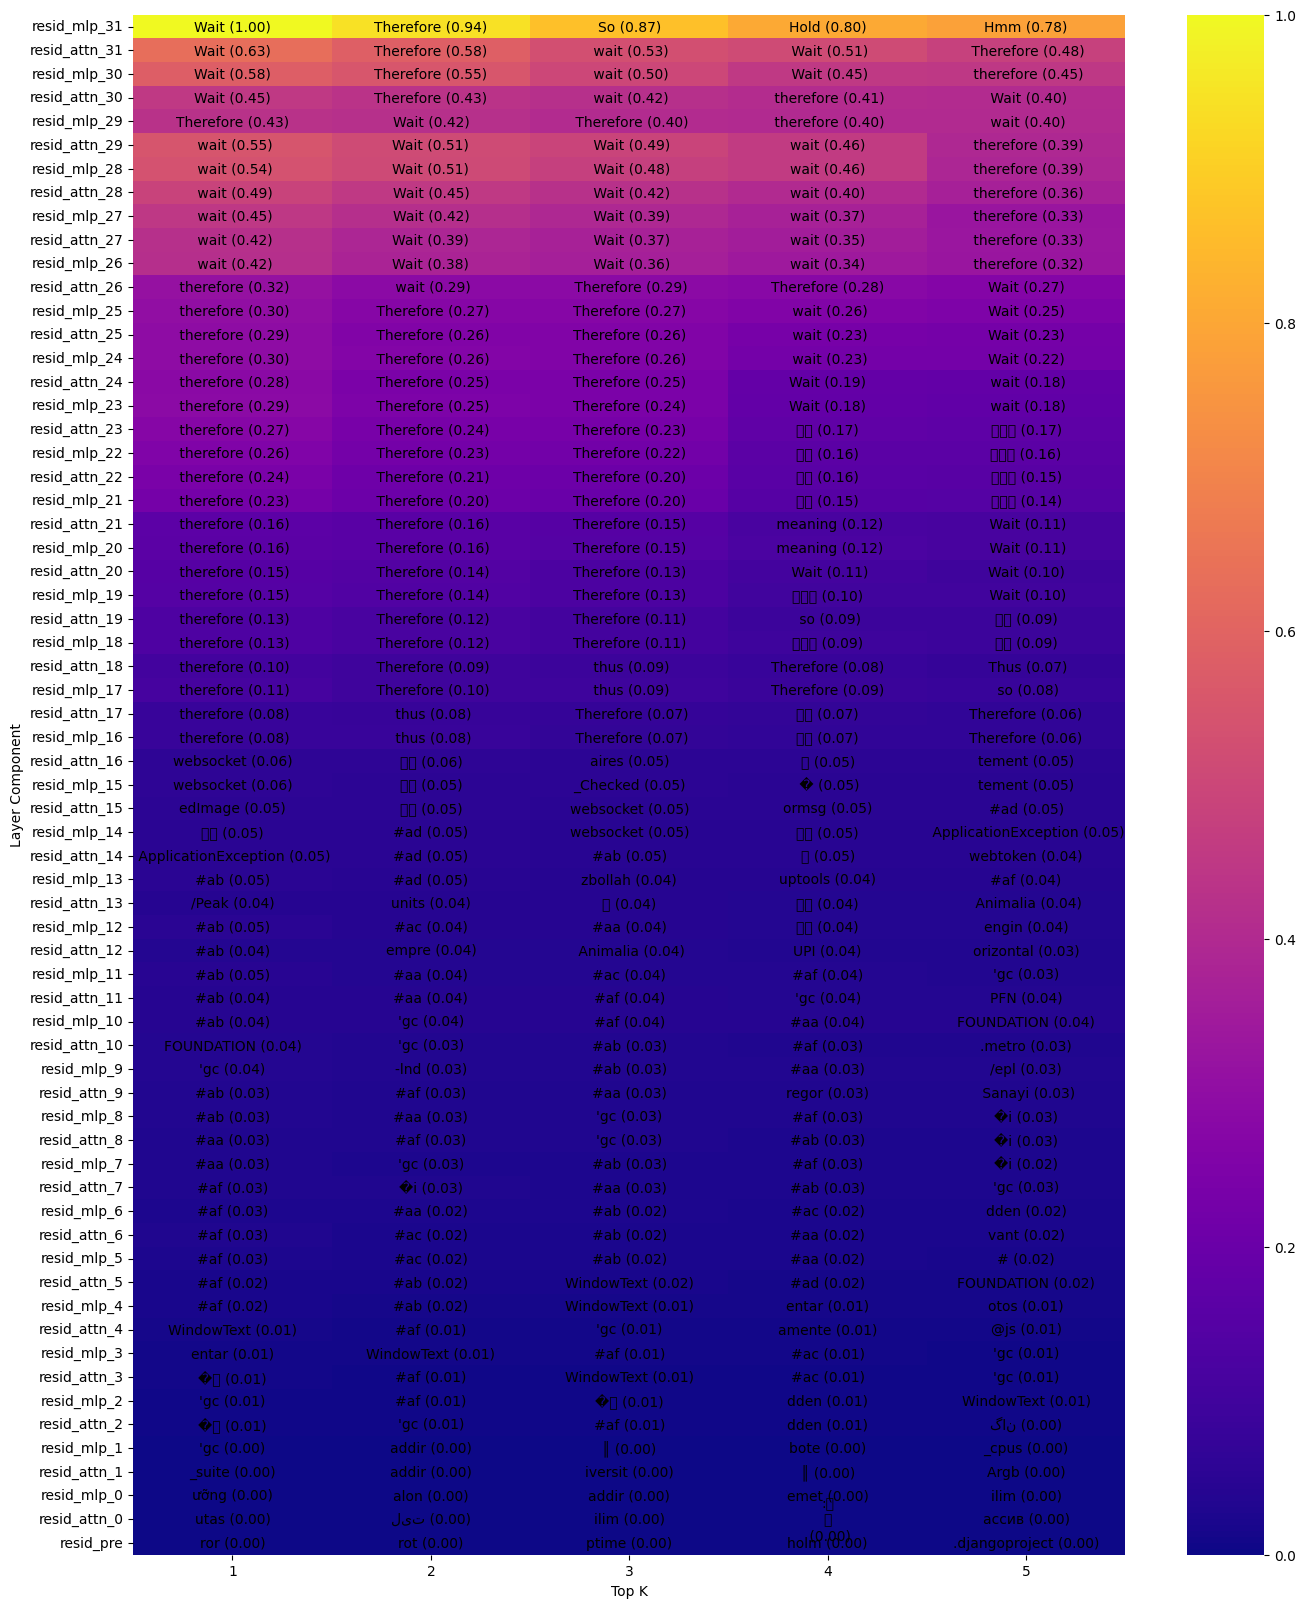

In [236]:
for d in ll_ds[0:]:
    input_ = d['input']
    with torch.no_grad():
        _,cache = model.run_with_cache(model.to_tokens(input_))
    init_state = cache['resid_pre',0][:,-1]
    accum = deepcopy(init_state)
    accum_resid = [init_state]
    for layer in range(model.cfg.n_layers):
        attn_out = cache[f'blocks.{layer}.hook_attn_out'][:,-1]
        accum = accum + attn_out
        accum_resid.append(accum)
        mlp_out = cache[f'blocks.{layer}.hook_mlp_out'][:,-1]
        accum = accum + mlp_out
        accum_resid.append(accum)
    accum_resid = cache.apply_ln_to_stack(torch.cat(accum_resid,dim = 0),layer = -1,pos_slice = -1) # num resid, d_model
    # projected_logit = (init_state.float() @ ans_tok_residual_stream.float()) # num components
    projected = einsum(accum_resid.float(), model.W_U.float(), 'layer d_model, d_model d_vocab -> layer d_vocab')
    top_5 = torch.topk(projected,5,dim = -1)
    layer_logits = top_5.values.detach().cpu().numpy()
    layer_logits = (layer_logits - layer_logits.min())/ (layer_logits.max() - layer_logits.min())
    layer_tokens = top_5.indices

    all_tokens = []
    for lt in layer_tokens:
        all_tokens.append(model.tokenizer.batch_decode(lt))
    all_tokens = np.array(all_tokens)

    layer_logits = layer_logits[::-1]
    all_tokens = all_tokens[::-1]

    fig, ax = plt.subplots(figsize=(16, 20))
    ytick_labels =  ['resid_pre'] +   sum([[f'resid_attn_{i}',f'resid_mlp_{i}'] for i in range(model.cfg.n_layers)],[])
    ytick_labels = ytick_labels[::-1]
    xtick_labels = list(range(1,6))
    sns.heatmap(
                layer_logits, 
                cmap="plasma",  # Color scheme
                annot=False,     # We will add custom annotations separately
                xticklabels=xtick_labels,
                yticklabels=ytick_labels,
                cbar=True        # Show color bar
            )
    for i in range(layer_logits.shape[0]):
        for j in range(layer_logits.shape[1]):
            text = f"{all_tokens[i, j]} ({layer_logits[i, j]:.2f})"  # String + Value
            ax.text(j + 0.5, i + 0.5, text, ha="center", va="center", color="black", fontsize=10)
    
    plt.xlabel("Top K")
    plt.ylabel("Layer Component")
    # Show plot
    plt.show()
    break

Find out which components contribute the most to these backtracking tokens: mlp or attentions?

In [72]:
all_layer_contributions = []
attn_acts = defaultdict(list)
mlp_acts = defaultdict(list)
for d in tqdm(ll_ds,total = len(ll_ds)):
    input_ = d['input']
    output_ = d['wait_token']
    output_embed = model.tokens_to_residual_directions(output_) # d_model
    with torch.no_grad():
        _,cache = model.run_with_cache(model.to_tokens(input_),names_filter = lambda x: 'attn_out' in x or 'mlp_out' in x or 'ln_final' in x)
    all_resid = []
    for layer in range(model.cfg.n_layers):
        all_resid.append(cache[f'blocks.{layer}.hook_attn_out'][:,-1])
        attn_acts[layer].append(cache[f'blocks.{layer}.hook_attn_out'][0,-1].detach().cpu()) # used to get mean activation for ablate.
        all_resid.append(cache[f'blocks.{layer}.hook_mlp_out'][:,-1])
        mlp_acts[layer].append(cache[f'blocks.{layer}.hook_mlp_out'][0,-1].detach().cpu())
    accum_resid = cache.apply_ln_to_stack(torch.cat(all_resid,dim = 0),layer = -1,pos_slice = -1) # num resid, d_model
    projected = einsum(accum_resid.float(), output_embed.float(), 'layer d_model, d_model -> layer')
    all_layer_contributions.append(projected.detach().cpu().numpy())
    del cache
    torch.cuda.empty_cache()

attn_acts = {k : torch.stack(v).mean(dim=0) for k,v in attn_acts.items()}
mlp_acts = {k: torch.stack(v).mean(dim=0) for k,v in mlp_acts.items()}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 388/388 [00:32<00:00, 11.77it/s]


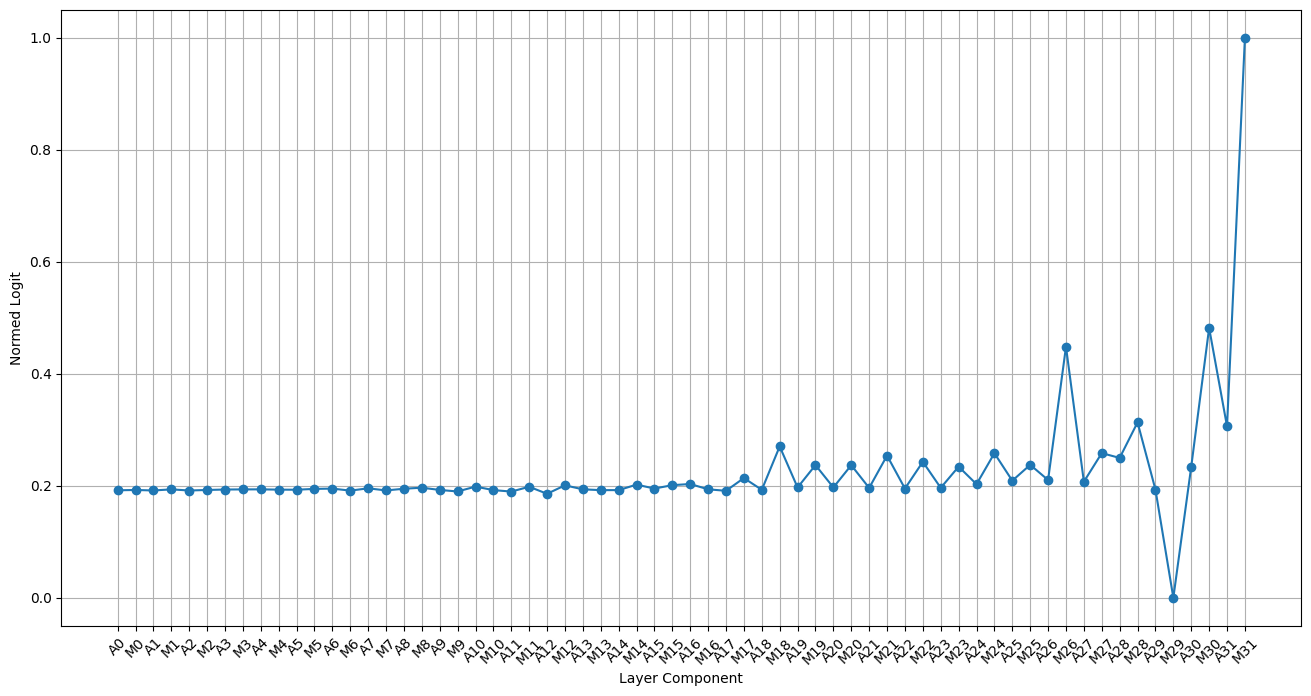

In [ ]:
x_tick_labels = sum([[f'A{i}',f'M{i}'] for i in range(model.cfg.n_layers)],[])
mean_contributions = np.stack([ norm(x) for x in all_layer_contributions]).mean(0)

fig = plt.figure(figsize=(16, 8))
plt.plot(x_tick_labels,mean_contributions,marker = 'o')
plt.xticks(rotation=45)
plt.ylabel('Normed Logit')
plt.xlabel('Layer Component')
plt.grid(True)
plt.show()

Attention layers have low direct effect, which is fine since it doesn't account for indirect effects. I still believe that attention layers must have a large effect on the model deciding to backtrack, since it should look at previous tokens and think that it has to backtrack and think further.

MLP 26/30 have a huge spike, which means the important information that leads to backtracking has been written by some previous attention heads to it, we can find these heads via mean/zero ablation on the last residual token to see how it affects that mlp output.

For attention ablation, we should do something like path patching, patch in at a specified attn layer til mlp_26/30, retrieve it and patch it in a separate run, so the effect is measured via drop in logit. So when we ablate an attention layer, we need to patch in all subsequent clean attention states (to isolate the effect just on that head/layer). We can still recompute the MLP (since it doesnt carry information but transform it).

In [89]:
def patch_hook(act,hook,patch):
    act[0,-1] = patch
    return act

patch_attn_contributions = defaultdict(list)

target_layer = [26,30] # target these 2 mlp to corrupt

for d in tqdm(ll_ds[:50],total = len(ll_ds[:50])): # try on first 50 samples
    model.reset_hooks()
    input_ = d['input']
    output_ = d['wait_token']
    # output_embed = model.tokens_to_residual_directions(output_) # d_model
    with torch.no_grad():
        original_logit,cache = model.run_with_cache(model.to_tokens(input_),names_filter = lambda x:'mlp_out' in x or 'ln_final' in x or 'attn_out' in x)
        # mlp_act = cache.apply_ln_to_stack(cache['blocks.26.hook_mlp_out'][:,-1],layer = -1,pos_slice = -1) # 1, d_model
        # mlp_contrib = (mlp_act.float() @ output_embed.float()).item()
        clean_act_act = [cache[f'blocks.{l}.hook_attn_out'][0,-1] for l in range(model.cfg.n_layers)]
        original_logit = original_logit[0,-1,output_].item()
        max_target_layer = max(target_layer)
        for layer in range(max_target_layer+1):
            model.reset_hooks()
            model.add_hook(f'blocks.{layer}.hook_attn_out',partial(patch_hook,patch = attn_acts[layer].to(model.cfg.device)))
            for l in range(layer+1,max_target_layer+1):
                model.add_hook(f'blocks.{layer}.hook_attn_out',partial(patch_hook,patch =clean_act_act[l]))
            
            _,patched_cache = model.run_with_cache(model.to_tokens(input_),names_filter = lambda x:'mlp_out' in x or 'ln_final' in x)
            model.reset_hooks()
            # patched_mlp_act = cache.apply_ln_to_stack(patched_cache['blocks.26.hook_mlp_out'][:,-1],layer = -1,pos_slice = -1)
            # patched_mlp_contrib = (patched_mlp_act.float() @ output_embed.float()).item()
            # patch_attn_contributions[layer].append(patched_mlp_contrib - mlp_contrib)
            for tl in target_layer:
                corrupted_mlp_act = patched_cache[f'blocks.{tl}.hook_mlp_out'][:,-1]
                model.add_hook(f'blocks.{tl}.hook_mlp_out',partial(patch_hook,patch = corrupted_mlp_act))
            patched_logit = model(model.to_tokens(input_))[0,-1,output_].item()
            patch_attn_contributions[layer].append(patched_logit - original_logit)

            del patched_cache
        del cache
    torch.cuda.empty_cache()

        




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:04<00:00,  4.89s/it]


In [90]:
patch_attn_contributions = {k: np.mean(v) for k,v in patch_attn_contributions.items()}
print (sorted(patch_attn_contributions.items(),key=lambda x:x[1],reverse=False)) # see which layer is most sensitive to the attn act.

[(1, -3.235), (0, -3.2275), (2, -2.9025), (3, -2.8325), (4, -2.425), (5, -1.13), (6, -0.3475), (16, -0.3125), (12, -0.2475), (25, -0.2475), (18, -0.2175), (7, -0.2125), (17, -0.21), (26, -0.21), (19, -0.2075), (21, -0.1975), (20, -0.1925), (23, -0.19), (24, -0.18), (11, -0.1725), (10, -0.165), (22, -0.155), (9, -0.15), (14, -0.15), (15, -0.15), (13, -0.145), (8, -0.14), (30, 0.0025), (29, 0.12), (28, 0.1425), (27, 0.19)]


# Try Probe to find Value vectors in MLP 
In andrew lee's experiment, he train a probe on verification vectors, we can do the same for backtracking, can we find value vectors that decide if the model should continue backtracking or not? 

1) Train probes on the 1st backtracking and wrapping vectors on the residual stream and label as 0/1
2) Using the value vectors of 0 = backtracking, find top K value vectors in each MLP layer and logit lens it to see if it represents "Wait"
3) Try to turn off those value vectors and see if model still output those tokens

In [238]:
class Probe(torch.nn.Module):
    def __init__(self, activation_dim, dtype=torch.bfloat16):
        super().__init__()
        self.net = torch.nn.Linear(activation_dim, 2, bias=True, dtype=dtype)

    def forward(self, x):
        logits = self.net(x).squeeze(-1)
        return logits
    
def train_probe(
    acts,
    labels=0,
    lr=1e-2,
    epochs=1,
    d_probe=model.cfg.d_model,
):
    probe = Probe(d_probe).to(model.cfg.device)
    optimizer = torch.optim.AdamW(probe.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    acc = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits = probe(acts)
        loss = criterion(logits, labels)
        pred = logits.argmax(-1)
        loss.backward()
        optimizer.step()
        acc.append((pred == labels).float().mean().item())
    return probe, acc

@torch.no_grad()
def test_probe(probe,acts,labels):
    pred = probe(acts).argmax(-1)
    return (pred == labels).float().mean().item()

In [239]:
# gather activations
probe_acts = defaultdict(list) # for each layer
probe_labels = []
for d in tqdm(ll_ds,total = len(ll_ds)):
    backtrack_input = d['input']
    wrap_input = d['wrapped_input']
    for i,inp_ in enumerate([backtrack_input,wrap_input]):
        _,cache = model.run_with_cache(model.to_tokens(inp_),names_filter = lambda x: 'resid_post' in x )
        for layer in range(model.cfg.n_layers):
            probe_acts[layer].append(cache['resid_post',layer][0,-1].detach().cpu())
        probe_labels.append(i)
        del cache

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [01:59<00:00,  3.22it/s]


In [242]:
# randomize the ids
ds_ids = list(range(len(probe_labels)))
ds_ids = torch.tensor(np.random.permutation(ds_ids))

probe_acts = {k: torch.stack(v)[ds_ids] for k,v in probe_acts.items()}
probe_labels = torch.tensor(probe_labels)[ds_ids]

# split to train/test
split = int(len(probe_labels) * 0.8)
train_acts = {k: v[:split] for k,v in probe_acts.items()}
train_labels = probe_labels[:split]
test_acts = {k: v[split:] for k,v in probe_acts.items()}
test_labels = probe_labels[split:]

TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

In [243]:
# train and test probe
torch.set_grad_enabled(True)
trained_probe = {}
for layer in range(model.cfg.n_layers):
    probe, acc = train_probe(train_acts[layer].to(model.cfg.device),train_labels.to(model.cfg.device),epochs = 3)
    test_acc = test_probe(probe,test_acts[layer].to(model.cfg.device),test_labels.to(model.cfg.device))
    print (f'Layer {layer} test acc: {test_acc:.2f}, train acc: {[np.round(a,2) for a in acc]}')
    trained_probe[layer] = probe

torch.set_grad_enabled(False)

# layer 8 to 24 almost perfect.

Layer 0 test acc: 0.88, train acc: [0.5, 0.88, 0.89]
Layer 1 test acc: 0.93, train acc: [0.51, 0.94, 0.94]
Layer 2 test acc: 0.94, train acc: [0.59, 0.95, 0.94]
Layer 3 test acc: 0.97, train acc: [0.45, 0.98, 0.98]
Layer 4 test acc: 0.97, train acc: [0.53, 0.98, 0.98]
Layer 5 test acc: 0.97, train acc: [0.6, 0.98, 0.98]
Layer 6 test acc: 0.99, train acc: [0.52, 0.99, 0.99]
Layer 7 test acc: 0.99, train acc: [0.52, 0.99, 0.99]
Layer 8 test acc: 0.99, train acc: [0.4, 0.99, 0.99]
Layer 9 test acc: 0.99, train acc: [0.64, 0.99, 0.99]
Layer 10 test acc: 0.99, train acc: [0.49, 0.99, 0.99]
Layer 11 test acc: 0.99, train acc: [0.09, 0.99, 0.99]
Layer 12 test acc: 0.99, train acc: [0.84, 0.99, 0.99]
Layer 13 test acc: 0.99, train acc: [0.86, 0.99, 0.99]
Layer 14 test acc: 0.99, train acc: [0.45, 0.99, 0.99]
Layer 15 test acc: 0.99, train acc: [0.55, 0.99, 0.99]
Layer 16 test acc: 0.99, train acc: [0.42, 0.99, 0.99]
Layer 17 test acc: 0.99, train acc: [0.69, 0.99, 0.99]
Layer 18 test acc: 0.99

In [247]:
# index mlp value via model.blocks[layer].mlp.W_out , key as W_in

top_indices = {}

for layer in range(6,model.cfg.n_layers):
    probe_vec = trained_probe[layer].net.weight.float() # (2,d_model)
    bt_vec = probe_vec[0] # 0 represents backtrack
    mlp_vec = model.blocks[layer].mlp.W_out.float() # (num value, d_model)

    # get top 5 value vec 
    cosin_sim = torch.nn.functional.cosine_similarity(mlp_vec,bt_vec)
    top_5 = torch.topk(cosin_sim,1000)
    top_5_vec_ids = top_5.indices
    top_5_vec = mlp_vec[top_5_vec_ids] # (5, d_model)
    top_indices[layer] = top_5_vec_ids

    bt_vec_opp = probe_vec[1]
    cosin_sim = torch.nn.functional.cosine_similarity(mlp_vec,bt_vec_opp)
    top_5_opp = torch.topk(cosin_sim,1000).indices
    top_5_opp_vec = mlp_vec[top_5_opp]
    # top_indices[layer] = torch.cat([top_5_vec_ids,top_5_opp],dim = 0)



    # unembed it directly.
    projected = einsum(top_5_opp_vec, model.W_U.float(), 'N d_model, d_model d_vocab -> N d_vocab')
    # for each vec , print top 10 words:
    # for i,proj in enumerate(projected):
    #     top_10 = torch.topk(proj,20)
    #     print (f'Layer {layer} vec {top_5_opp[i]}: {model.tokenizer.batch_decode(top_10.indices)}')

In [248]:
# Try switching it off and see how model generates
layers_to_switch_off = range(6,32)

# copy the model params and store it
original_mlp_params = {}
for layer in layers_to_switch_off:
    original_mlp_params[layer] = model.blocks[layer].mlp.W_out.data.clone()

def switch_off_params(model,layers_to_switch_off):
    for layer in layers_to_switch_off:
        indices = top_indices[layer]
        with torch.no_grad():
            model.blocks[layer].mlp.W_out[indices] = 0.

def switch_on_params(model,layers_to_switch_off):
    for layer in layers_to_switch_off:
        with torch.no_grad():
            model.blocks[layer].mlp.W_out.data.copy_(original_mlp_params[layer])



In [251]:
for d in ll_ds:
    input_ = d['input']
    # ori_logit = model(model.to_tokens(input_))[0,-1]
    # ori_pred = ori_logit.argmax(-1).item()
    ori_gen = generate_with_hook(model,model.to_tokens(input_),max_new_tokens = 500)[0]
    switch_off_params(model,layers_to_switch_off)
    switched_gen = generate_with_hook(model,model.to_tokens(input_),max_new_tokens = 500)[0]
    # steered_logit = model(model.to_tokens(input_))[0,-1]
    # steered_pred = steered_logit.argmax(-1).item()
    # steered_wait_logit = steered_logit[ori_pred]
    # print (f'Original token: {model.tokenizer.decode([ori_pred])}, logit: {ori_logit[ori_pred].item()}, steered_token: {model.tokenizer.decode([steered_pred])}, steered_logit: {steered_wait_logit.item()}')
    pprint(f'Original: {ori_gen}')
    pprint(f'Switched: {switched_gen}')
    switch_on_params(model,layers_to_switch_off)

    break

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Original: Wait, let me double-check that. If each candy bar is $5, then 12 candy bars would cost │
│ 12 times 5, which is 60. Yep, that matches up. So, Marissa can buy 12 candy bars for her brother │
│ Jimmy.                                                                                           │
│                                                                                                  │
│ I don't think I made any mistakes here. She started with $80, spent $20 on the ball, leaving her │
│ with $60. Divided by $5 per candy bar gives 12. Seems straightforward. I don't see any           │
│ complications or additional steps needed. So, I think 12 is the correct answer.                  │
│                                                                                                  │
│ **Final Answer**                                                                                 │
│ Marissa bought \boxed{12} candy bars for Jimmy.                                                  │
│ </think>                                                                                         │
│                                                                                                  │
│ Marissa bought a ball for $20. She initially had $80, so she subtracted the cost of the ball     │
│ from her total money:                                                                            │
│                                                                                                  │
│ [ 80 - 20 = 60 \]                                                                                │
│                                                                                                  │
│ She then used the remaining $60 to buy candy bars, each costing $5. To find out how many candy   │
│ bars she could buy, she divided the remaining money by the price per candy bar:                  │
│                                                                                                  │
│ [ 60 \div 5 = 12 \]                                                                              │
│                                                                                                  │
│ Thus, Marissa bought \boxed{12} candy bars for Jimmy.                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Switched: Wait, let me double-check to make sure I didn't make a mistake. She started with $80,  │
│ spent $20 on the ball, which leaves her with $60. Each candy bar is $5, and $60 divided by $5 is │
│ 12. Yeah, that seems right. So, she can buy 12 candy bars for her brother Jimmy.                 │
│                                                                                                  │
│ I think that's the answer. But let me go through it again to make sure. Starting money: $80.     │
│ Minus the cost of the ball: $20. So, $80 - $20 = $60. Then, each candy bar is $5. So, $60        │
│ divided by $5 is 12. So, 12 candy bars. Yep, that makes sense. I don't think I missed anything   │
│ here. It seems straightforward.                                                                  │
│                                                                                                  │
│ So, the number of candy bars Marissa bought for her brother Jimmy is 12. I feel confident about  │
│ this answer now.                                                                                 │
│                                                                                                  │
│ **Final Answer**                                                                                 │
│ Marissa bought \boxed{12} candy bars for Jimmy.                                                  │
│ </think>                                                                                         │
│                                                                                                  │
│ Marissa bought a ball for $20. She initially had $80, so she subtracted $20 from $80, leaving    │
│ her with $60. She used this $60 to buy candy bars, each costing $5. To find out how many candy   │
│ bars she could buy, she divided $60 by $5, which gave her 12.                                    │
│                                                                                                  │
│ Thus, the number of candy bars Marissa bought for her brother Jimmy is \boxed{12}.               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

# Attribution patching on last token pos 
Or we could just do knockout with mean-ablation for each component at the last token to see which components are important. Do attribution patching with the corrupted act as the mean-activation.

We collect the grads and acts for attribution patching and pattern to see the tokens focused by the important attention heads as a proxy for token relevance score.

In [146]:
comp_names = {'mlp':'blocks.{l}.hook_mlp_out','attn':'blocks.{l}.attn.hook_z','resid': 'blocks.{l}.hook_resid_post'}

def cache_hook(act, hook, cache,take_last_only):
    if take_last_only:
        cache[hook.name].append(act[0,-1].detach().cpu())
    else:
        cache[hook.name].append(act[0].detach().cpu())

def pattern_hook(act,hook,cache):
    cache[hook.name].append(act[0,:,-1].detach().cpu()) # pattern is (b,head_index, q, k) # take last q

def interpolate_hook(act,hook,alpha,mean_vec):
    act = ((1-alpha) * act) + (alpha * mean_vec[hook.name].to(act.device))
    return act

def attribution(mean_act,original_act,grad):
    return ((mean_act - original_act) * grad).sum(dim = -1) # sum over d_model and mean over batch

def get_attribution_scores(act_cache,grad_cache,comps,take_last = False,stack_samples = False,mean_act=None):
    if mean_act is None:
        mean_act = {k:torch.stack([vv.mean(0) for vv in v]).mean(dim=0) for k,v in act_cache.items()} 
    if take_last: # only take last token pos for act.
        act_cache = {k: [vv[-1] for vv in v] for k,v in act_cache.items()}
    comp_attr = {}
    for comp in comps:
        layer_attr = []
        for layer in range(model.cfg.n_layers):
            comp_n = comp_names[comp].format(l=layer)
            if stack_samples:
                act = torch.stack(act_cache[comp_n])
                grad = torch.stack(grad_cache[comp_n])
                layer_attr.append(attribution(mean_act[comp_n].unsqueeze(0).expand_as(act),act,grad))
            else:
                sample_layer_attr = []
                for act,grad in zip(act_cache[comp_n],grad_cache[comp_n]):
                    sample_layer_attr.append(attribution(mean_act[comp_n].unsqueeze(0).expand_as(act),act,grad))
                layer_attr.append(sample_layer_attr)
        comp_attr[comp] = layer_attr
    return comp_attr

def get_mean_activations(ds,model,comps): # get mean acts
    acts = defaultdict(list)
    for d in ds:
        _,cache = model.run_with_cache(model.to_tokens(d['input']))
        for l in range(model.cfg.n_layers):
            for comp in comps:
                comp_n = comp_names[comp].format(l=l)
                acts[comp_n].append(cache[comp_n][0].detach().cpu())
        del cache
        torch.cuda.empty_cache()
    return acts

def attribution_patching(ds,model,comp = 'attn_mlp',interpolate_steps = 1,num_samples = 100): # comp either attn_mlp or residual , if residual, we save all tokens else only last token for attn/mlp, interpolate_steps is the number of steps to integrate the gradients over.
    torch.set_grad_enabled(True) # enable it 
    act_cache = defaultdict(list)
    grad_cache = defaultdict(list)
    pattern_cache = defaultdict(list) # store attn patterns
    model.reset_hooks()
    if comp == 'attn_mlp':
        names_filter = lambda x: 'attn.hook_z' in x or 'mlp_out' in x
        pattern_filter = lambda x: 'attn.hook_pattern' in x
        comps = ['attn','mlp']
        stack_samples = True
        take_last = True
    else:
        names_filter = lambda x: 'resid_post' in x
        comps = ['resid']
        stack_samples = False
        take_last = False

    mean_acts = None
    if interpolate_steps > 1: # if integrating gradients over num steps, we need to first get the acts/mean acts then get the gradients.
        act_cache = get_mean_activations(ds[:num_samples],model,comps)
        mean_acts = {}
        for comp_n,acts in act_cache.items():
            mean_acts[comp_n] = torch.stack([v.mean(0) for v in acts]).mean(dim = 0)
        integrated_grad_cache = defaultdict(list) # to store the mean grads
    

    for i,d in tqdm(enumerate(ds[:num_samples]),total = len(ds[:num_samples])):
        input_ = d['input']
        output_ = torch.tensor(d['wait_token']).to(model.cfg.device)
        for step in range(interpolate_steps):
            model.reset_hooks()
            if comp == 'attn_mlp':
                if interpolate_steps == 1:
                    model.add_hook(names_filter,partial(cache_hook,cache = act_cache,take_last_only=False),'fwd')
                    model.add_hook(pattern_filter,partial(pattern_hook,cache = pattern_cache),'fwd') 
                elif interpolate_steps > 1 and step == 0: # only for 1st
                    model.add_hook(pattern_filter,partial(pattern_hook,cache = pattern_cache),'fwd')

                model.add_hook(names_filter,partial(cache_hook,cache = grad_cache,take_last_only=True),'bwd')
            else:
                if interpolate_steps == 1:
                    model.add_hook(names_filter,partial(cache_hook,cache = act_cache,take_last_only=False),'fwd')
                    
                model.add_hook(names_filter,partial(cache_hook,cache = grad_cache,take_last_only=False),'bwd')
            if interpolate_steps > 1:
                alpha = step/interpolate_steps
                model.add_hook(names_filter ,partial(interpolate_hook,alpha = alpha,mean_vec = mean_acts),'fwd') # assign the interpolated act
            logit = model(model.to_tokens(input_).to(model.cfg.device))[:,-1,output_]
            logit.backward()
            torch.cuda.empty_cache()
        if interpolate_steps > 1:
            for k,v in grad_cache.items():
                integrated_grad_cache[k].append(torch.stack(v).mean(0)) # mean over num steps
            grad_cache = defaultdict(list) # reset grad_cache
    if interpolate_steps > 1:
        grad_cache = integrated_grad_cache

    torch.set_grad_enabled(False) # disable again
    model.reset_hooks()
    comp_attr = get_attribution_scores(act_cache,grad_cache,comps,take_last = take_last,stack_samples = stack_samples,mean_act=mean_acts)
    return comp_attr,pattern_cache



In [41]:
attn_mlp_comp_attr,pattern_cache = attribution_patching(ll_ds,model,comp = 'attn_mlp')
attn_attr = attn_mlp_comp_attr['attn']
mlp_attr = attn_mlp_comp_attr['mlp']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 386/386 [03:03<00:00,  2.10it/s]


In [44]:
mean_attn_attr = attn_attr.mean(0)
mean_mlp_attr = mlp_attr.mean(0)  # layer

combined = np.concatenate([mean_mlp_attr.reshape(-1,1),mean_attn_attr],axis = 1) # (Layer + Head)

def imshow(tensor, ylabel=None, xlabel=None, x_axis_label=None, y_axis_label=None, width=800, height=600, **kwargs):
    fig = px.imshow(
        tensor,
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
        **kwargs,
    )
    
    # Set tick labels if provided
    if ylabel is not None:
        fig.update_yaxes(tickmode='array', tickvals=list(range(len(ylabel))), ticktext=ylabel)
    if xlabel is not None:
        fig.update_xaxes(tickmode='array', tickvals=list(range(len(xlabel))), ticktext=xlabel)

    # Set figure size and axis labels
    fig.update_layout(
        width=width,
        height=height,
        xaxis_title=x_axis_label,
        yaxis_title=y_axis_label,
    )

    fig.show()

imshow(mean_attn_attr,ylabel = list(range(mean_attn_attr.shape[0])),xlabel = list(range(mean_attn_attr.shape[1])),title = 'Attention Attribution', x_axis_label = 'Head', y_axis_label = 'Layer')
line(mean_mlp_attr,x_labels = list(range(mean_mlp_attr.shape[0])),x_label = 'Layer',y_label = 'MLP Attribution',title = 'MLP Attribution')

Looking at indirect effect, MLP 30 seems to be v important, while attention heads at last layer is important

# Activation Patching (optional)
To check if aligns with attribution patching with mean knockout, seems to align pretty ok. MLP_30 and last attn layer head 3,14,31 seems to have high effect (look at negative)

This will take longer even with the KV trick.

In [90]:
# use AP to check
def patch_hook(act,hook,patch,sample_id,head_index = None):
    if head_index is None:
        act[sample_id,-1] = patch
    else:
        act[sample_id,-1,head_index] = patch # for attn head
    return act

def repeat_past_kv_cache(kv_cache,size,until_pos=-1):
    kv_cache_copy = deepcopy(kv_cache)
    for l in range(len(kv_cache_copy.entries)): # layer
        kv_cache_copy.entries[l].past_keys = kv_cache.entries[l].past_keys.repeat(size,1,1,1)[:,:until_pos] # 4D
        kv_cache_copy.entries[l].past_values = kv_cache.entries[l].past_values.repeat(size,1,1,1)[:,:until_pos] # 4D
    kv_cache_copy.previous_attention_mask = kv_cache.previous_attention_mask.repeat(size,1,)[:,:until_pos] # 2d
    return kv_cache_copy

bz = 32
all_attn_ie = []
all_mlp_ie = []

for d in tqdm(ll_ds[:5],total = len(ll_ds[:5])):
    model.reset_hooks()
    input_ = d['input']
    output_ = d['wait_token']

    attn_comps = [f'blocks.{l}.attn.hook_z-{ll}' for l in range(model.cfg.n_layers) for ll in range(model.cfg.n_heads)]
    mlp_comps = [f'blocks.{l}.hook_mlp_out' for l in range(model.cfg.n_layers)]

    past_kv_cache = HookedTransformerKeyValueCache.init_cache(model.cfg, model.cfg.device, 1)
    input_ids = model.to_tokens(input_)

    clean_logit = model(input_ids,past_kv_cache = past_kv_cache)[0,-1,output_].item()

    attn_ie = []
    mlp_ie = []
    # get attn IE
    for i in range(0,len(attn_comps),bz):
        model.reset_hooks()
        comps = attn_comps[i:i+bz]
        repeated_inputs = input_ids.repeat(len(comps),1)[:,-1:] # take only last token becuz gonna use past_kv_cache
        curr_past_kv_cache = repeat_past_kv_cache(past_kv_cache,len(comps))

        for j,comp in enumerate(comps):
            comp,head_index = comp.split('-')
            head_index = int(head_index)
            model.add_hook(comp,partial(patch_hook,patch = mean_act[comp][head_index],sample_id = j,head_index = head_index))
        attn_logits = model(repeated_inputs,past_kv_cache = curr_past_kv_cache)[:,-1,output_].detach().cpu()
        attn_ie.append(attn_logits - clean_logit)
        del curr_past_kv_cache

    # MLP IE
    for i in range(0,len(mlp_comps),bz):
        model.reset_hooks()
        comps = mlp_comps[i:i+bz]
        repeated_inputs = input_ids.repeat(len(comps),1)[:,-1:] # take only last token becuz gonna use past_kv_cache
        curr_past_kv_cache = repeat_past_kv_cache(past_kv_cache,len(comps))

        for j,comp in enumerate(comps):
            model.add_hook(comp,partial(patch_hook,patch = mean_act[comp],sample_id = j))
        mlp_logits = model(repeated_inputs,past_kv_cache = curr_past_kv_cache)[:,-1,output_].detach().cpu()
        mlp_ie.append(mlp_logits - clean_logit)
        del curr_past_kv_cache
    torch.cuda.empty_cache()

    all_attn_ie.append(torch.cat(attn_ie,dim=0))
    all_mlp_ie.append(torch.cat(mlp_ie,dim=0))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:35<00:00,  7.16s/it]


In [94]:
mean_attn_ap = torch.stack(all_attn_ie).mean(dim=0).reshape(model.cfg.n_layers,model.cfg.n_heads)
mean_mlp_ap = torch.stack(all_mlp_ie).mean(dim=0)

combined_ap = torch.cat([mean_mlp_ap.unsqueeze(1),mean_attn_ap],dim=1).float().detach().cpu()
imshow(mean_attn_ap.float(),ylabel = list(range(mean_attn_ap.shape[0])),xlabel = list(range(mean_attn_ap.shape[1])),title = 'Attention Attribution using Activation Patching', x_axis_label = 'Head', y_axis_label = 'Layer')

# Token level score

For each sample, average the attention patch of the top 3 heads and view. (along the key direction.)

In [252]:
import matplotlib as mpl
def get_word_level_scores(string,token_scores,offsets):
    words = string.split()
    word_spans = []
    start = 0
    for word in words:
        start_idx = string.find(word, start)
        end_idx = start_idx + len(word)
        word_spans.append((start_idx, end_idx))
        start = end_idx
    word_scores = []
    word_to_tokens = {}
    for j,( word_start, word_end) in enumerate(word_spans):
        token_indices = [
            i for i, (tok_start, tok_end) in enumerate(offsets)
            if tok_end > word_start and tok_start < word_end
        ]
        score_sum = token_scores[token_indices].sum().item()
        word_scores.append(score_sum)
        word_to_tokens[j] = token_indices
    return word_scores,word_to_tokens,words


def plot_wrapped_colored_words(words, word_scores, max_chars=75):
    # Normalize scores and pick a colormap
    norm = mpl.colors.Normalize(vmin=min(word_scores), vmax=max(word_scores))
    cmap = mpl.cm.viridis  # lighter = higher value

    fig, ax = plt.subplots(figsize=(14, 10))

    # Parameters for wrapping
    h_spacing = 0.3  # Horizontal spacing per character
    v_spacing = 1.0  # Vertical spacing per line
    current_chars = 0
    current_line = 0

    for word, score in zip(words, word_scores):
        word_len = len(word)
        # If adding this word (plus a space) goes beyond max_chars, wrap to new line
        if current_chars + word_len + 1 > max_chars:
            current_line += 1
            current_chars = 0

        # Compute the position in data coordinates
        x = current_chars * h_spacing
        y = -current_line * v_spacing
        ax.text(x, y, word, color=cmap(norm(score)), fontsize=10, ha='left', va='baseline')

        # Advance the character count (add 1 for the space after the word)
        current_chars += word_len + 1

    # Add colorbar
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label('Score (lighter = higher value)', rotation=270, labelpad=15)

    # Adjust plot limits so all text is visible
    plt.xlim(0, max_chars * h_spacing + 2)
    # current_line holds the index of the last line used, so the total number of lines is current_line + 1
    plt.ylim(-current_line * v_spacing - 1, 1)
    plt.axis('off')
    plt.show()

def plot_token_level_score(ds,idx,top_heads= 1,plot = True,score_type = 'attn_mlp',**kwargs):
    input_ = ds[idx]['input']
    next_sent = ds[idx]['truncated_next_passage']
    tokenized = model.tokenizer(input_,return_offsets_mapping=True,add_special_tokens=False)
    if score_type == 'attn_mlp':
        attn_ie = torch.tensor(kwargs['attn_attr'][idx]) # from the attribution patching
        _,top_k_idx = torch.topk(attn_ie.flatten(), top_heads,largest=False) # take min
        layer,head = torch.div(top_k_idx, attn_ie.shape[1], rounding_mode='floor'), top_k_idx % attn_ie.shape[1]
        scores = [kwargs['pattern_cache'][f'blocks.{l}.attn.hook_pattern'][idx][h] for l,h in zip(layer,head)] # each value is len of ll_ds and shape of vec = (head index, token len)
        scores = torch.stack(scores).mean(0)
        normalized_out_scores = scores[0] + scores[-1] # last token and 1st have high scores.
        scores = scores[1:-1]/(1.0 - normalized_out_scores) # normalize by 1 - last token score and remove last token
        input_truncated = input_.split(model.tokenizer.bos_token)[1] # remove the bos token
        offset_mapping = tokenized['offset_mapping'][1:-1] # remove the bos and last
    else: # is residual
        scores = [kwargs['resid_scores'][l][idx].float() for l in range(model.cfg.n_layers)] # each item is a vector of len = len tokenized
        scores = np.stack(scores,axis = 0).max(0)[1:] # mean over layers and remove bos token
        offset_mapping = tokenized['offset_mapping'][1:] # remove the bos token
        input_truncated = input_.split(model.tokenizer.bos_token)[1] # remove the bos token

    # get string-level scores
    word_scores,word_to_tokens,words = get_word_level_scores(input_truncated,scores,offset_mapping)
    ranked_word_indices = np.argsort(word_scores)[::-1]
    top_10_words = [words[i] for i in ranked_word_indices[:10]]
    if not plot: # if not plot, just return the top words
        return top_10_words
    plot_wrapped_colored_words(words,word_scores)
    answer_idx = len(word_scores)-1
    answer_rank = np.where(ranked_word_indices == answer_idx)[0][0]
    print (f'Answer: {ds[idx]["answer"]}, score rank/score: {answer_rank}/{word_scores[-1]:.3f}')
    print (f'Top 10 words: {top_10_words}')
    pprint (f'next 100 words: {next_sent}')
    

def token_score_interval(ds,top_heads = 1,score_type = 'attn_mlp',num_samples = 100,**kwargs):
    all_ques_scores = []
    all_cot_scores = []
    for i,d in enumerate(ds[:num_samples]):
        input_ = d['input']
        tokenized = model.tokenizer(input_,add_special_tokens=False).input_ids
        if score_type == 'attn_mlp':
            attn_ie = torch.tensor(kwargs['attn_attr'][i]) # from the attribution patching
            _,top_k_idx = torch.topk(attn_ie.flatten(), top_heads,largest=False) # take min
            layer,head = torch.div(top_k_idx, attn_ie.shape[1], rounding_mode='floor'), top_k_idx % attn_ie.shape[1]
            scores = [kwargs['pattern_cache'][f'blocks.{l}.attn.hook_pattern'][i][h] for l,h in zip(layer,head)] # each value is len of ll_ds and shape of vec = (head index, token len)
            scores = torch.stack(scores).mean(0)
            normalized_out_scores = scores[0] + scores[-1] # last token and 1st have high scores.
            scores = scores[1:-1]/(1.0 - normalized_out_scores) # normalize by 1 - last token score and remove last token
        else: # is residual
            scores = [kwargs['resid_scores'][l][i].float() for l in range(model.cfg.n_layers)] # each item is a vector of len = len tokenized
            scores = np.stack(scores,axis = 0).max(0)[1:] # mean over layers and remove bos token

        # split into question and cot
        think_id = model.tokenizer.encode('<think>',add_special_tokens=False)[0]
        ques_end = tokenized.index(think_id)
        ques_scores = scores[:ques_end+1].sum().item()
        cot_scores = scores[ques_end+1:]
        # bin cot_scores into 5
        bin_size = np.ceil(len(cot_scores)/5).astype(int)
        cot_scores = [cot_scores[i:i+bin_size].sum().item() for i in range(0,len(cot_scores),bin_size)]

        if score_type != 'attn_mlp':
            combined_scores = [ques_scores] + cot_scores
            normed_scores = (combined_scores - np.min(combined_scores))/(np.max(combined_scores) - np.min(combined_scores))
            ques_scores = normed_scores[0]
            cot_scores = normed_scores[1:]

        all_ques_scores.append(ques_scores)
        all_cot_scores.append(cot_scores)
        
    return np.mean(all_ques_scores),np.array(all_cot_scores).mean(axis = 0)


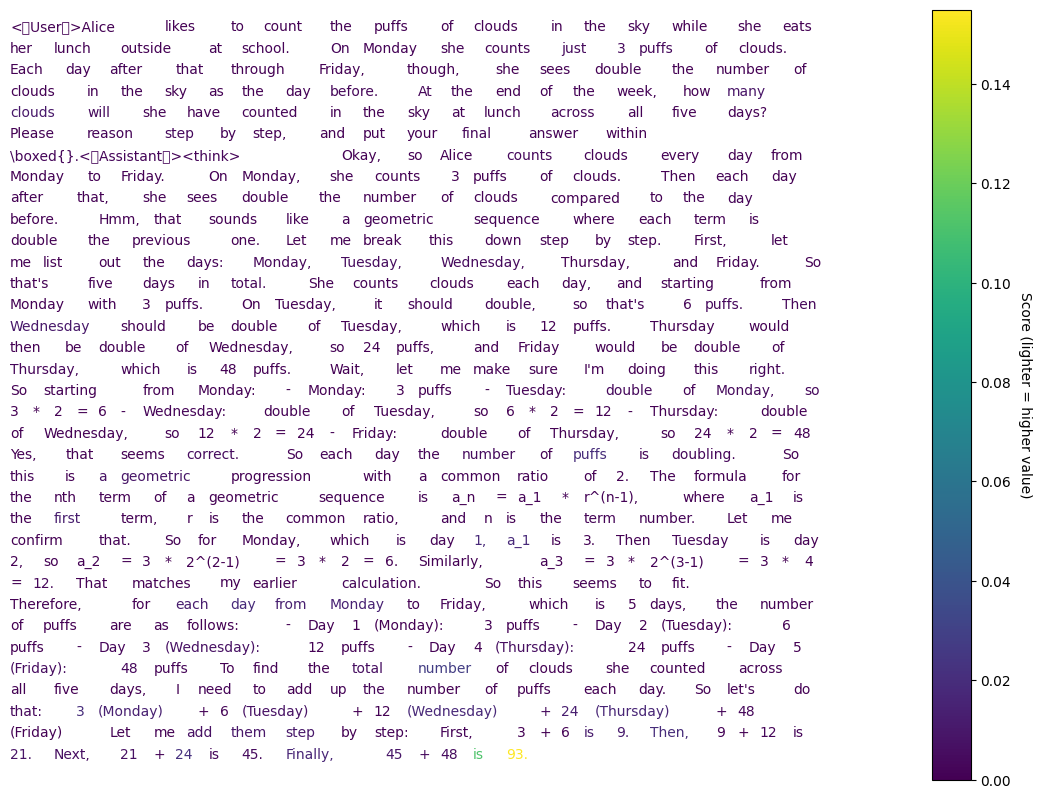

Answer: 93, score rank/score: 0/0.155
Top 10 words: ['93.', 'is', 'number', '24', '3', 'Then,', 'puffs', 'day', 'a_1', '1,']


In [55]:
plot_token_level_score(ll_ds,50,1,score_type = 'attn_mlp',pattern_cache = pattern_cache,attn_attr = attn_attr) # example 11 looks at the word another.

High attention score seems to be attributed towards more recent CoT portion while little is given to the question.

In [279]:
for top_heads in range(1,6): # measure via looking at either top 1,2 ,... 5 heads
    ques_scores,cot_scores = token_score_interval(ll_ds,top_heads,score_type = 'attn_mlp',pattern_cache = pattern_cache,attn_attr = attn_attr)
    print (f'Attn score averaged over top {top_heads} heads: Ques: {ques_scores:.2f}, CoT (binned into 20%): {[np.round(c,2) for c in cot_scores]}')

Attn score averaged over top 1 heads: Ques: 0.05, CoT (binned into 20%): [0.07, 0.06, 0.08, 0.16, 0.58]
Attn score averaged over top 2 heads: Ques: 0.07, CoT (binned into 20%): [0.09, 0.07, 0.08, 0.13, 0.56]
Attn score averaged over top 3 heads: Ques: 0.08, CoT (binned into 20%): [0.11, 0.08, 0.09, 0.13, 0.5]
Attn score averaged over top 4 heads: Ques: 0.08, CoT (binned into 20%): [0.11, 0.08, 0.08, 0.12, 0.54]
Attn score averaged over top 5 heads: Ques: 0.07, CoT (binned into 20%): [0.1, 0.07, 0.07, 0.12, 0.58]


# Residual Attribution patching (token-level)

The above first finds top attention heads and average the attention score to act as token-relevance. We can also do the same for residual states but across all tokens, the corrupted would just be mean-ablation derived from averaging across seq and batch for each state.

In [154]:
# resid_act_cache,resid_grad_cache,_ = attribution_patching(ll_ds,model,comp = 'residual')
resid_attr,_ = attribution_patching(ll_ds,model,comp = 'resid',interpolate_steps = 10,num_samples = 100) # list of layers of list of samples

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:05<00:00,  4.86s/it]


In [194]:
non_interpolate_resid_attr,_ = attribution_patching(ll_ds,model,comp = 'resid',interpolate_steps = 1,num_samples = 100) # no interpolate

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s]


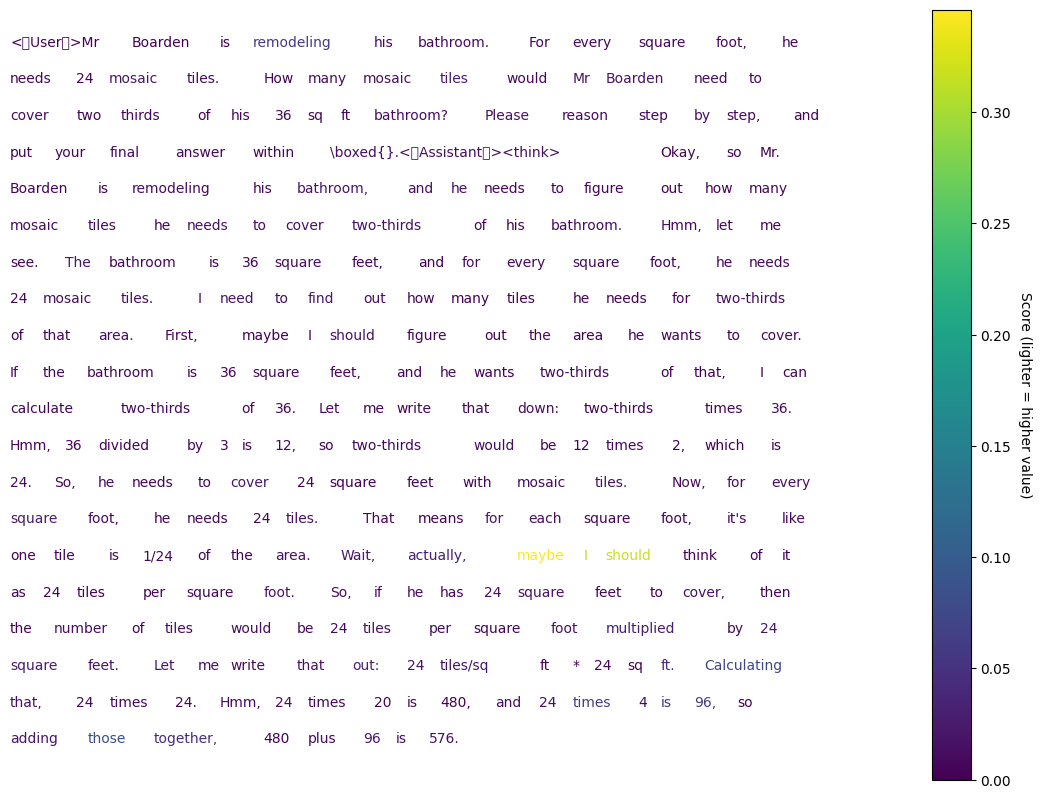

Answer: 576, score rank/score: 57/0.012
Top 10 words: ['maybe', 'should', 'I', 'those', 'Calculating', '96,', 'remodeling', 'times', 'is', 'together,']


╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│ next 100 words: So, 24 times 24 is 576. Therefore, he needs 576 tiles for 24 square feet. Wait,  │
│ let me double-check that. If each square foot requires 24 tiles, then 1 square foot is 24 tiles. │
│ So, 24 square feet would be 24 times 24, which is 576 tiles. Yeah, that makes sense. So, 576     │
│ tiles in total. Alternatively, I can think of it as the area to cover is 24 square feet, and     │
│ each tile covers 1/24 of a square foot. So, the number of tiles needed would be the area divided │
│ by the area per tile. So, 24 divided by                                                          │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

In [257]:
plot_token_level_score(ll_ds,80,1,True,score_type = 'residual',resid_scores = resid_attr['resid']) #80/99/75/85 have some examples (could we take the top 10 tokens highlighted and check if they are present in the next 100 words? -> some level of faithfulness here??)

In [229]:
resid_ques_scores,resid_cot_scores = token_score_interval(ll_ds,1,score_type = 'residual',num_samples = 100,resid_scores = non_interpolate_resid_attr['resid'])
print (f'Residual IE : Ques: {resid_ques_scores:.2f}, CoT (binned into 20%): {[np.round(c,2) for c in resid_cot_scores]}')

Residual IE : Ques: 0.63, CoT (binned into 20%): [0.16, 0.14, 0.21, 0.38, 0.77]


: 

: 

: 

In [223]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
top_10_words = []

math_op_mapping = {'plus':['+','plus'],'minus':['-','minus'],'multiply':['*','multiply','times'],'divide':['/','divided','divide']}

word_overlap = []
for i in range(len(non_interpolate_resid_attr['resid'][0])):
    top_words = plot_token_level_score(ll_ds,i,1,False,score_type = 'residual',resid_scores = non_interpolate_resid_attr['resid'])
    top_words = [w for w in top_words if w not in stop_words]
    top_10_words.extend(top_words)
    next_sent = ll_ds[i]['truncated_next_passage']
    is_in = 0
    for word in top_words:
        if word in math_op_mapping:
            word = math_op_mapping[word]
            for w in word:
                if w in next_sent:
                    is_in += 1
                    break
        else:
            is_in += (word in next_sent)
    
    word_overlap.append(is_in/len(top_words))
top_10_words = Counter(top_10_words)
top_10_words = top_10_words.most_common(20)
print (f'Top 10 words in residual attribution: {top_10_words}')
print (f'Important words present in next 100 words %: {np.mean(word_overlap)*100:.2f}')

[nltk_data] Downloading package stopwords to
[nltk_data]     /export/home2/weijie210/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 10 words in residual attribution: [('figure', 30), ('plus', 19), ('total', 17), ('that.', 14), ('number', 12), ('calculate', 12), ('Please', 11), ('that:', 9), ('says', 9), ('subtract', 8), ('reason', 8), ('problem', 8), ('step', 8), ('need', 8), ('break', 7), ('Let', 7), ('minus', 7), ('Hmm,', 7), ('divided', 6), ('times', 6)]
Important words present in next 100 words %: 41.81


In [224]:
word_overlap = np.argsort(word_overlap)[::-1] 
print (word_overlap[:10])

[68 64 85 22 23 62 27 13 83 33]
